In [57]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of datasets to compare
CLOUDS = ['5080_54435', 'alcoy', 'bildstein_station1_xyz_intensity_rgb']

# Input and output folders
PLOT_FOLDER = os.path.join("out", "plots")
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Function to get the file based on the specified timestamp in the filename
def get_file_by_date(folder, date_str):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {folder}")
    
    if date_str == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        latest_file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),  # Join list and then replace
            "%Y-%m-%d-%H:%M:%S"  # Correct datetime format
        ))
        print(f"Loading latest file: {latest_file}")
        return latest_file
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            timestamp_str = filename.split('-')[1:]  # Split to get timestamp part
            timestamp_str = '-'.join(timestamp_str).replace('.csv', '')  # Rebuild timestamp string
            
            if date_str == timestamp_str:
                print(f"Loading file: {file}")
                return file
        raise FileNotFoundError(f"File with date '{date_str}' not found in folder: {folder}")

# Read the latest file for each dataset
dfs = {}
for cloud in CLOUDS:
    folder = os.path.join("out", cloud)
    data = get_file_by_date(folder, 'latest')
    df = pd.read_csv(data)
    # Convert times to milliseconds
    df['mean'] = df['mean'] * 1000
    df['stdev'] = df['stdev'] * 1000
    dfs[cloud] = df




Loading latest file: out/5080_54435/5080_54435-2024-11-28-15:55:38.csv
Loading latest file: out/alcoy/alcoy-2024-11-28-18:51:50.csv
Loading latest file: out/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2024-11-28-15:23:19.csv


In [18]:
df['octree']

0       pointer<Lpoint>
1       pointer<Lpoint>
2       pointer<Lpoint>
3       pointer<Lpoint>
4       pointer<Lpoint>
             ...       
155    linear<Lpoint64>
156    linear<Lpoint64>
157    linear<Lpoint64>
158    linear<Lpoint64>
159    linear<Lpoint64>
Name: octree, Length: 160, dtype: object

In [19]:
# Define a consistent color palette for 'octree' categories
octree_types = set()  # Initialize an empty set
for df in dfs.values():
    octree_types.update(df['octree'].unique())  # Add unique octree values from each dataset

octree_types = sorted(octree_types)  # Sort the octree types
palette = sns.color_palette("Set2", len(octree_types))  # Generate the color palette
color_dict = dict(zip(octree_types, palette))  # Map each octree type to a color

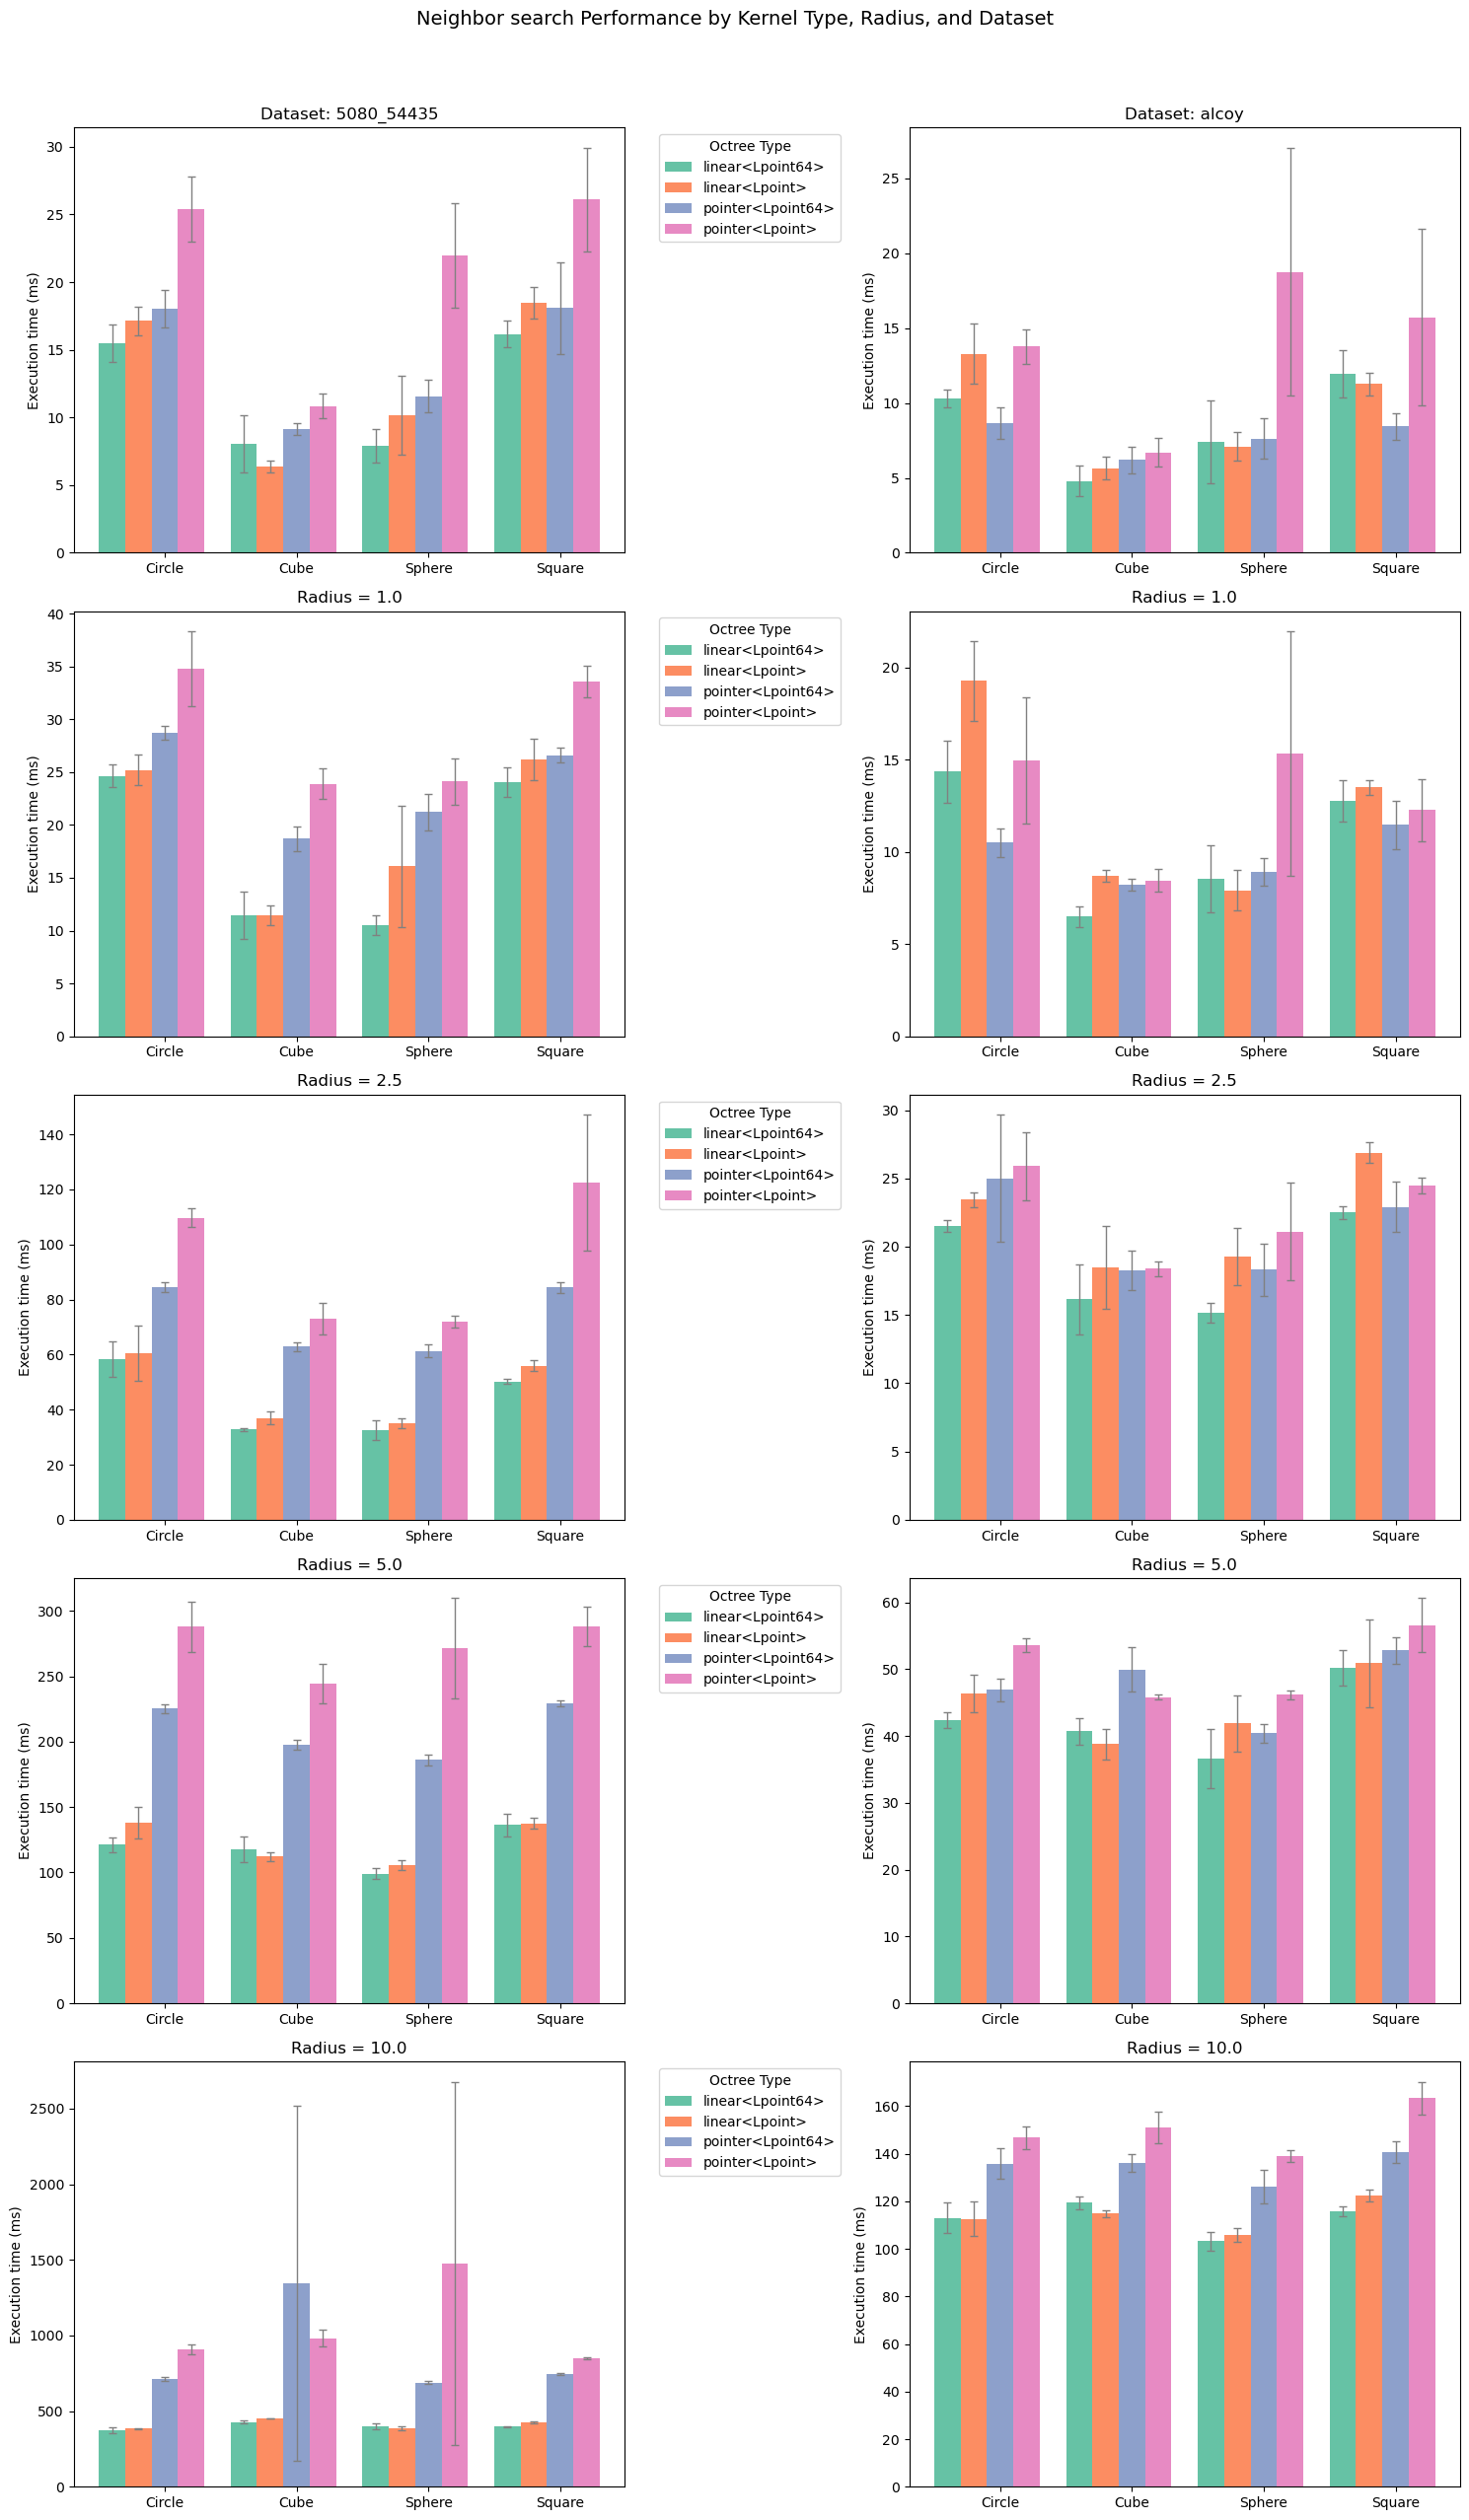

In [20]:

# Function to create a performance plot matrix
def create_comparison_plot_matrix(dfs, operation, operation_name):
    # Create subplot grid: rows for radii, columns for datasets
    radii = sorted(dfs[next(iter(dfs))]['radius'].unique())  # Assume radii are the same across datasets
    kernels = sorted(dfs[next(iter(dfs))]['kernel'].unique())
    
    # Define grid size (rows = radii, cols = datasets)
    fig, axes = plt.subplots(len(radii), len(dfs), figsize=(15, 5 * len(radii)))
    
    if len(radii) == 1:
        axes = [axes]  # Ensure axes is always a 2D array if only one radius
    
    bar_width = 0.2  # Adjusted bar width for multiple octree types
    
    # Iterate over datasets and radii
    for col_idx, (dataset, df) in enumerate(dfs.items()):
        # Filter for the specified operation
        operation_df = df[df['operation'] == operation]
        
        # Create plots for each radius
        for row_idx, radius in enumerate(radii):
            ax = axes[row_idx][col_idx]
            radius_data = operation_df[operation_df['radius'] == radius]
            
            x_positions = range(len(kernels))
            for i, kernel in enumerate(kernels):
                kernel_data = radius_data[radius_data['kernel'] == kernel]
                
                for j, (octree, octree_data) in enumerate(kernel_data.groupby('octree')):
                    # Bar positions for the current octree type
                    x = [pos + (j - len(octree_types) / 2) * bar_width for pos in x_positions]
                    
                    # Extract means and standard deviations
                    means = octree_data['mean'].values
                    stdevs = octree_data['stdev'].values
                    
                    # Plot bars and error bars
                    ax.bar(x[i], means[0], bar_width,
                           color=color_dict[octree],
                           label=octree if i == 0 else "")
                    ax.errorbar(x[i], means[0], stdevs[0],
                                color='gray', capsize=3, capthick=1,
                                fmt='none', elinewidth=1)
            
            # Customize each subplot
            ax.set_xticks(range(len(kernels)))
            ax.set_xticklabels(kernels)
            ax.set_title(f'Radius = {radius}')
            ax.set_ylabel('Execution time (ms)')
            
            # Add legend to the first column
            if col_idx == 0:
                ax.legend(title='Octree Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set dataset-specific title for each column
        axes[0][col_idx].set_title(f'Dataset: {dataset}')
    
    # Add overall title
    fig.suptitle(operation_name + ' Performance by Kernel Type, Radius, and Dataset', y=1.02, fontsize=14)
    
    plt.tight_layout()
    return fig

# Create the comparison plot for 'neighSearch'
fig = create_comparison_plot_matrix(dfs, 'neighSearch', 'Neighbor search')
plt.savefig(os.path.join(PLOT_FOLDER, 'neighbor_search_comparison.png'), dpi=300, bbox_inches='tight')


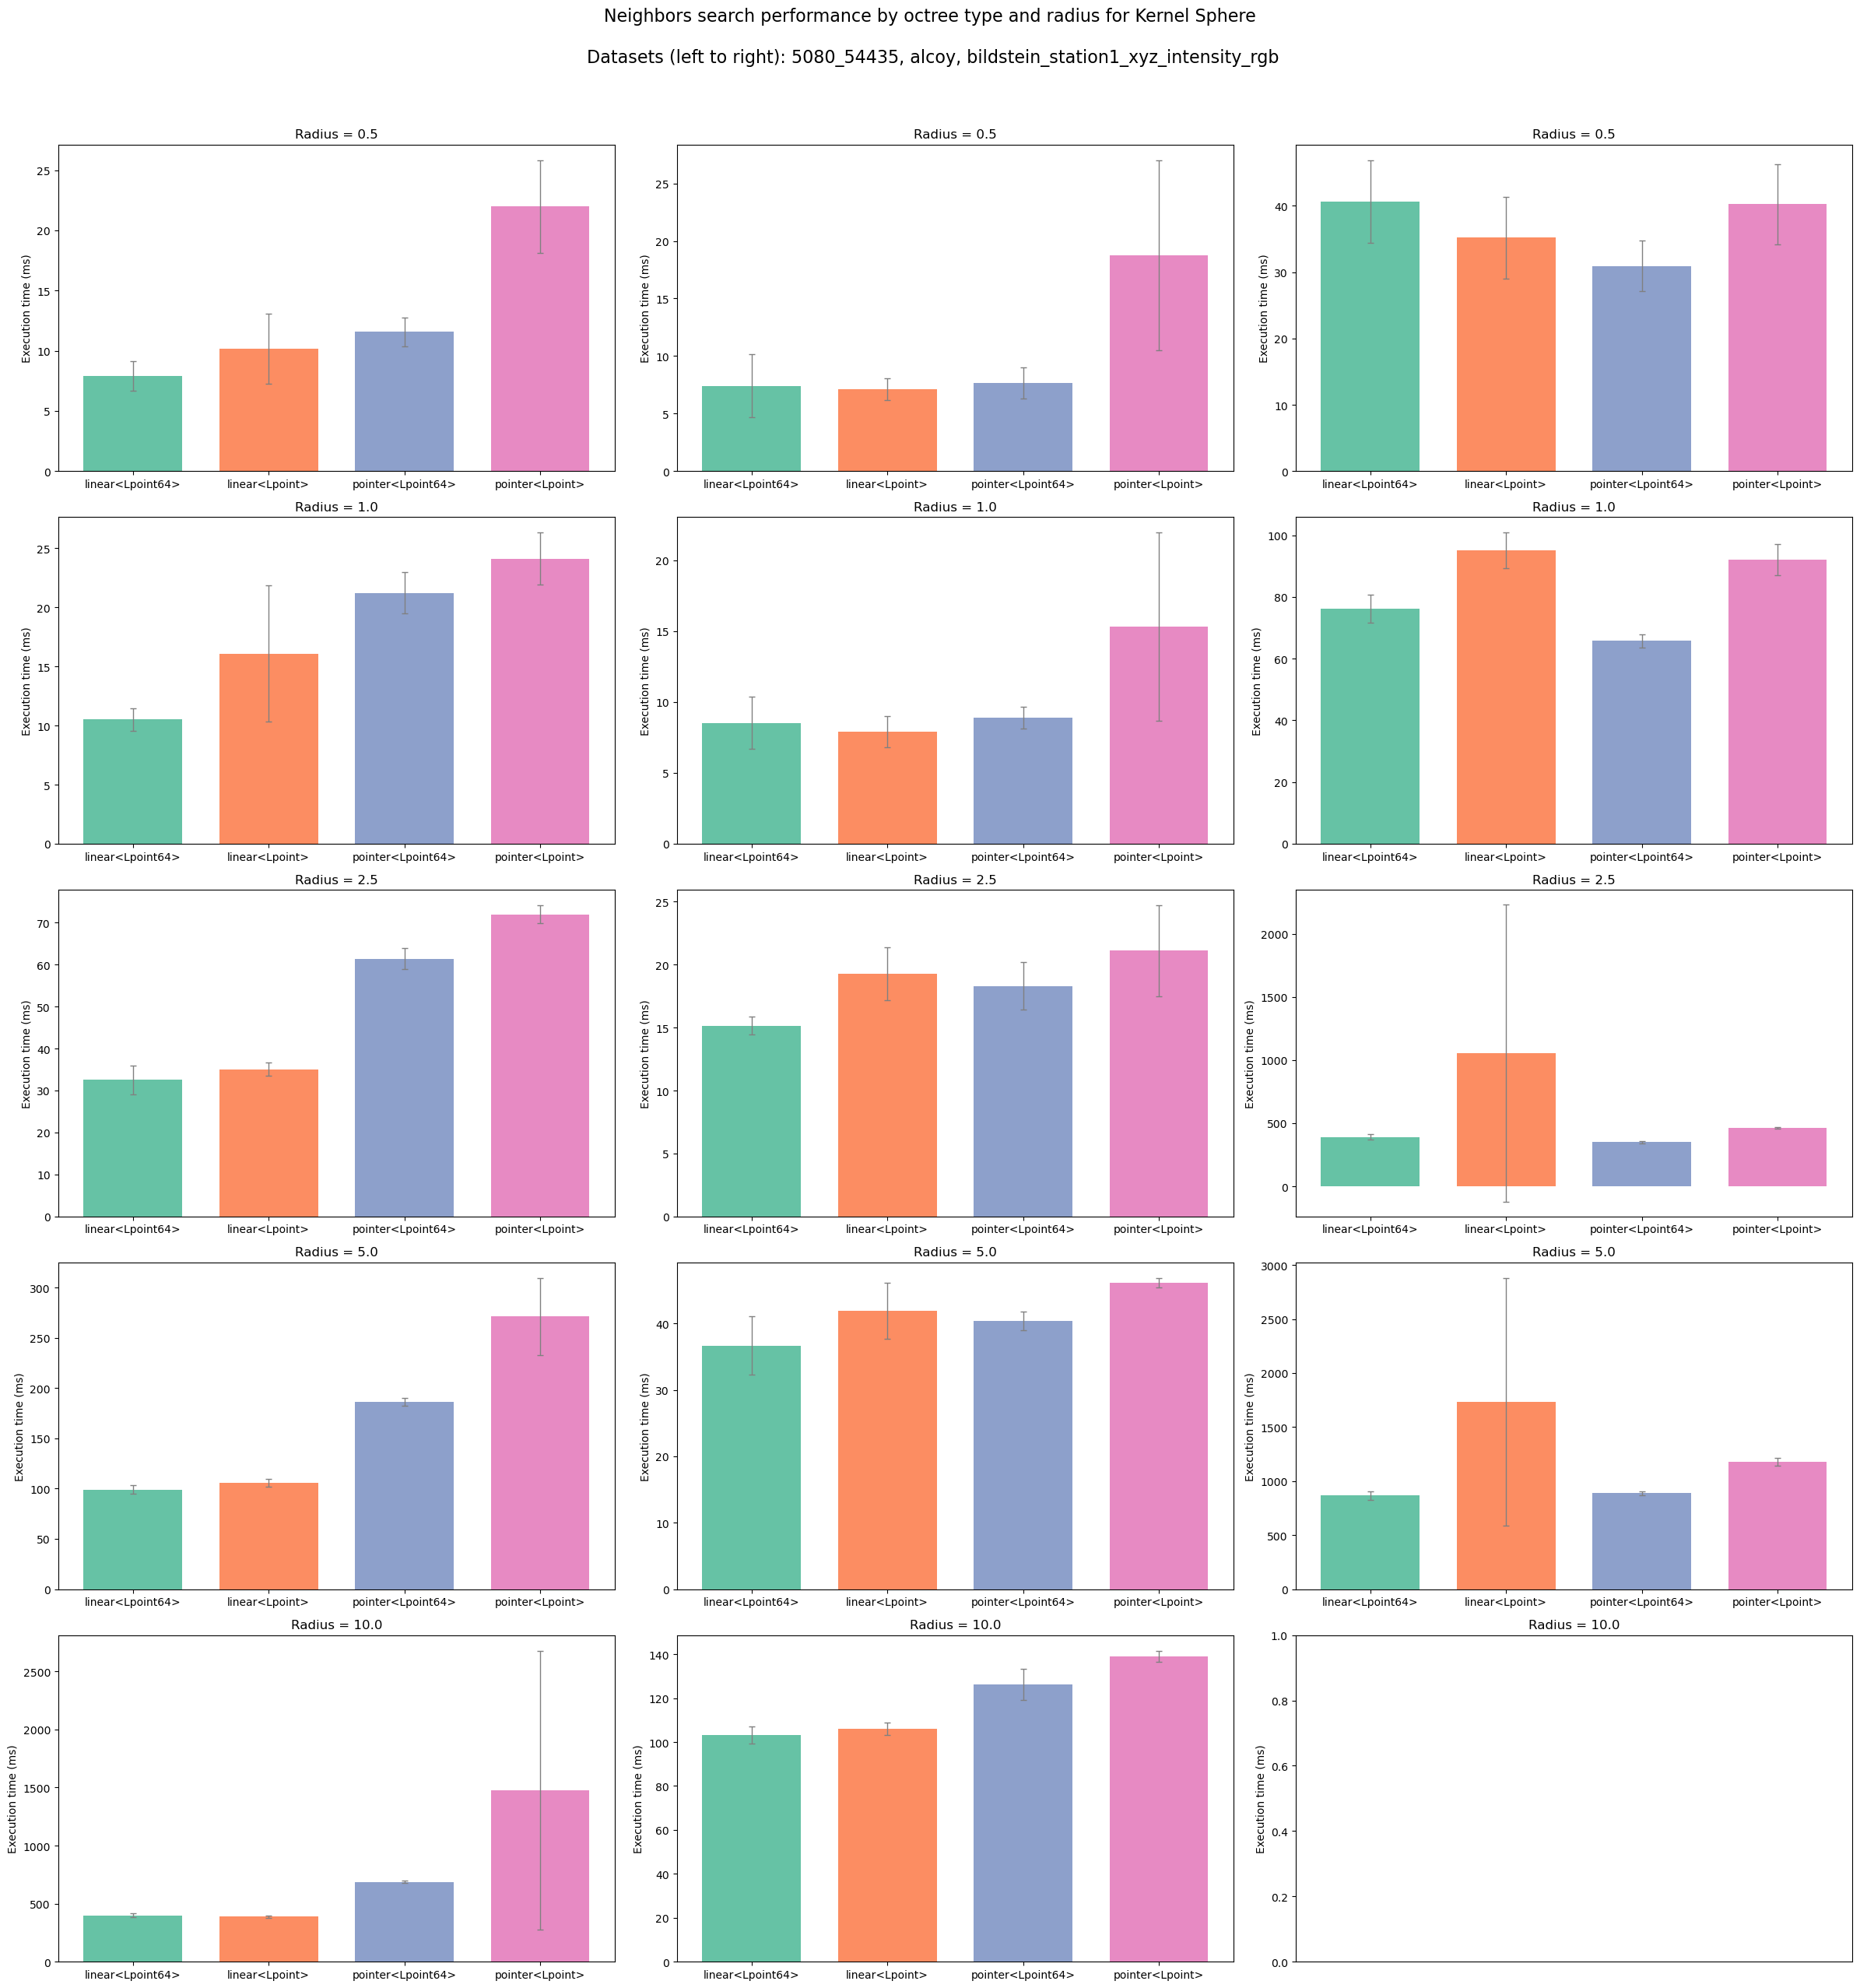

In [74]:
# Function to create a performance plot matrix
def create_comparison_plot_matrix(dfs, kernel, operation, operation_name):
    # Create subplot grid: rows for radii, columns for datasets
    radii = sorted(dfs[next(iter(dfs))]['radius'].unique())  # Assume radii are the same across datasets
    
    # Define grid size (rows = radii, cols = datasets)
    fig, axes = plt.subplots(len(radii), len(dfs), figsize=(8 * len(dfs), 5 * len(radii)))
    
    if len(radii) == 1:
        axes = [axes]  # Ensure axes is always a 2D array if only one radius
    
    bar_width = 0.8  # Adjusted bar width for multiple octree types, reduce if too wide
    bar_gap = 0.1  # Space between bars

    # Iterate over datasets and radii
    for col_idx, (dataset, df) in enumerate(dfs.items()):
        # Filter for the specified operation
        operation_df = df[df['operation'] == operation]
        
        # Create plots for each radius
        for row_idx, radius in enumerate(radii):
            ax = axes[row_idx][col_idx]
            radius_data = operation_df[operation_df['radius'] == radius]
            
            # Only include 'sphere' kernel
            sphere_data = radius_data[radius_data['kernel'] == kernel]
            
            # Sort octree types to ensure consistent order
            octree_types_sorted = sorted(sphere_data['octree'].unique())

            # Adjust spacing between bars based on sorted octree types
            for i, octree in enumerate(octree_types_sorted):
                octree_data = sphere_data[sphere_data['octree'] == octree]
                
                # Extract means and standard deviations
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                
                # Position bars with adjusted spacing
                x_pos = i * (1 + bar_gap)  # Increase gap if needed
                
                # Plot bars and error bars for each octree
                ax.bar(x_pos, means[0], bar_width, color=color_dict[octree], label=octree)
                ax.errorbar(x_pos, means[0], stdevs[0], color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
            
            # Customize each subplot
            ax.set_xticks([i * (1 + bar_gap) for i in range(len(octree_types_sorted))])  # Adjust x-tick positions
            ax.set_xticklabels(octree_types_sorted)
            ax.set_ylabel('Execution time (ms)')
            
            # Set radius title above the graph
            ax.set_title(f'Radius = {radius}')
    
    # Add overall title
    dataset_names = ', '.join(dfs.keys())  # Join dataset names with a comma
    fig.suptitle(operation_name + f' performance by octree type and radius for Kernel {kernel}\n\n Datasets (left to right): {dataset_names}', y=1.02, fontsize=16)
    
    plt.tight_layout()
    return fig

# Create the comparison plot for 'neighSearch'
fig = create_comparison_plot_matrix(dfs, "Sphere", 'neighSearch', 'Neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'neighbor_search_comparison.png'), dpi=300, bbox_inches='tight')


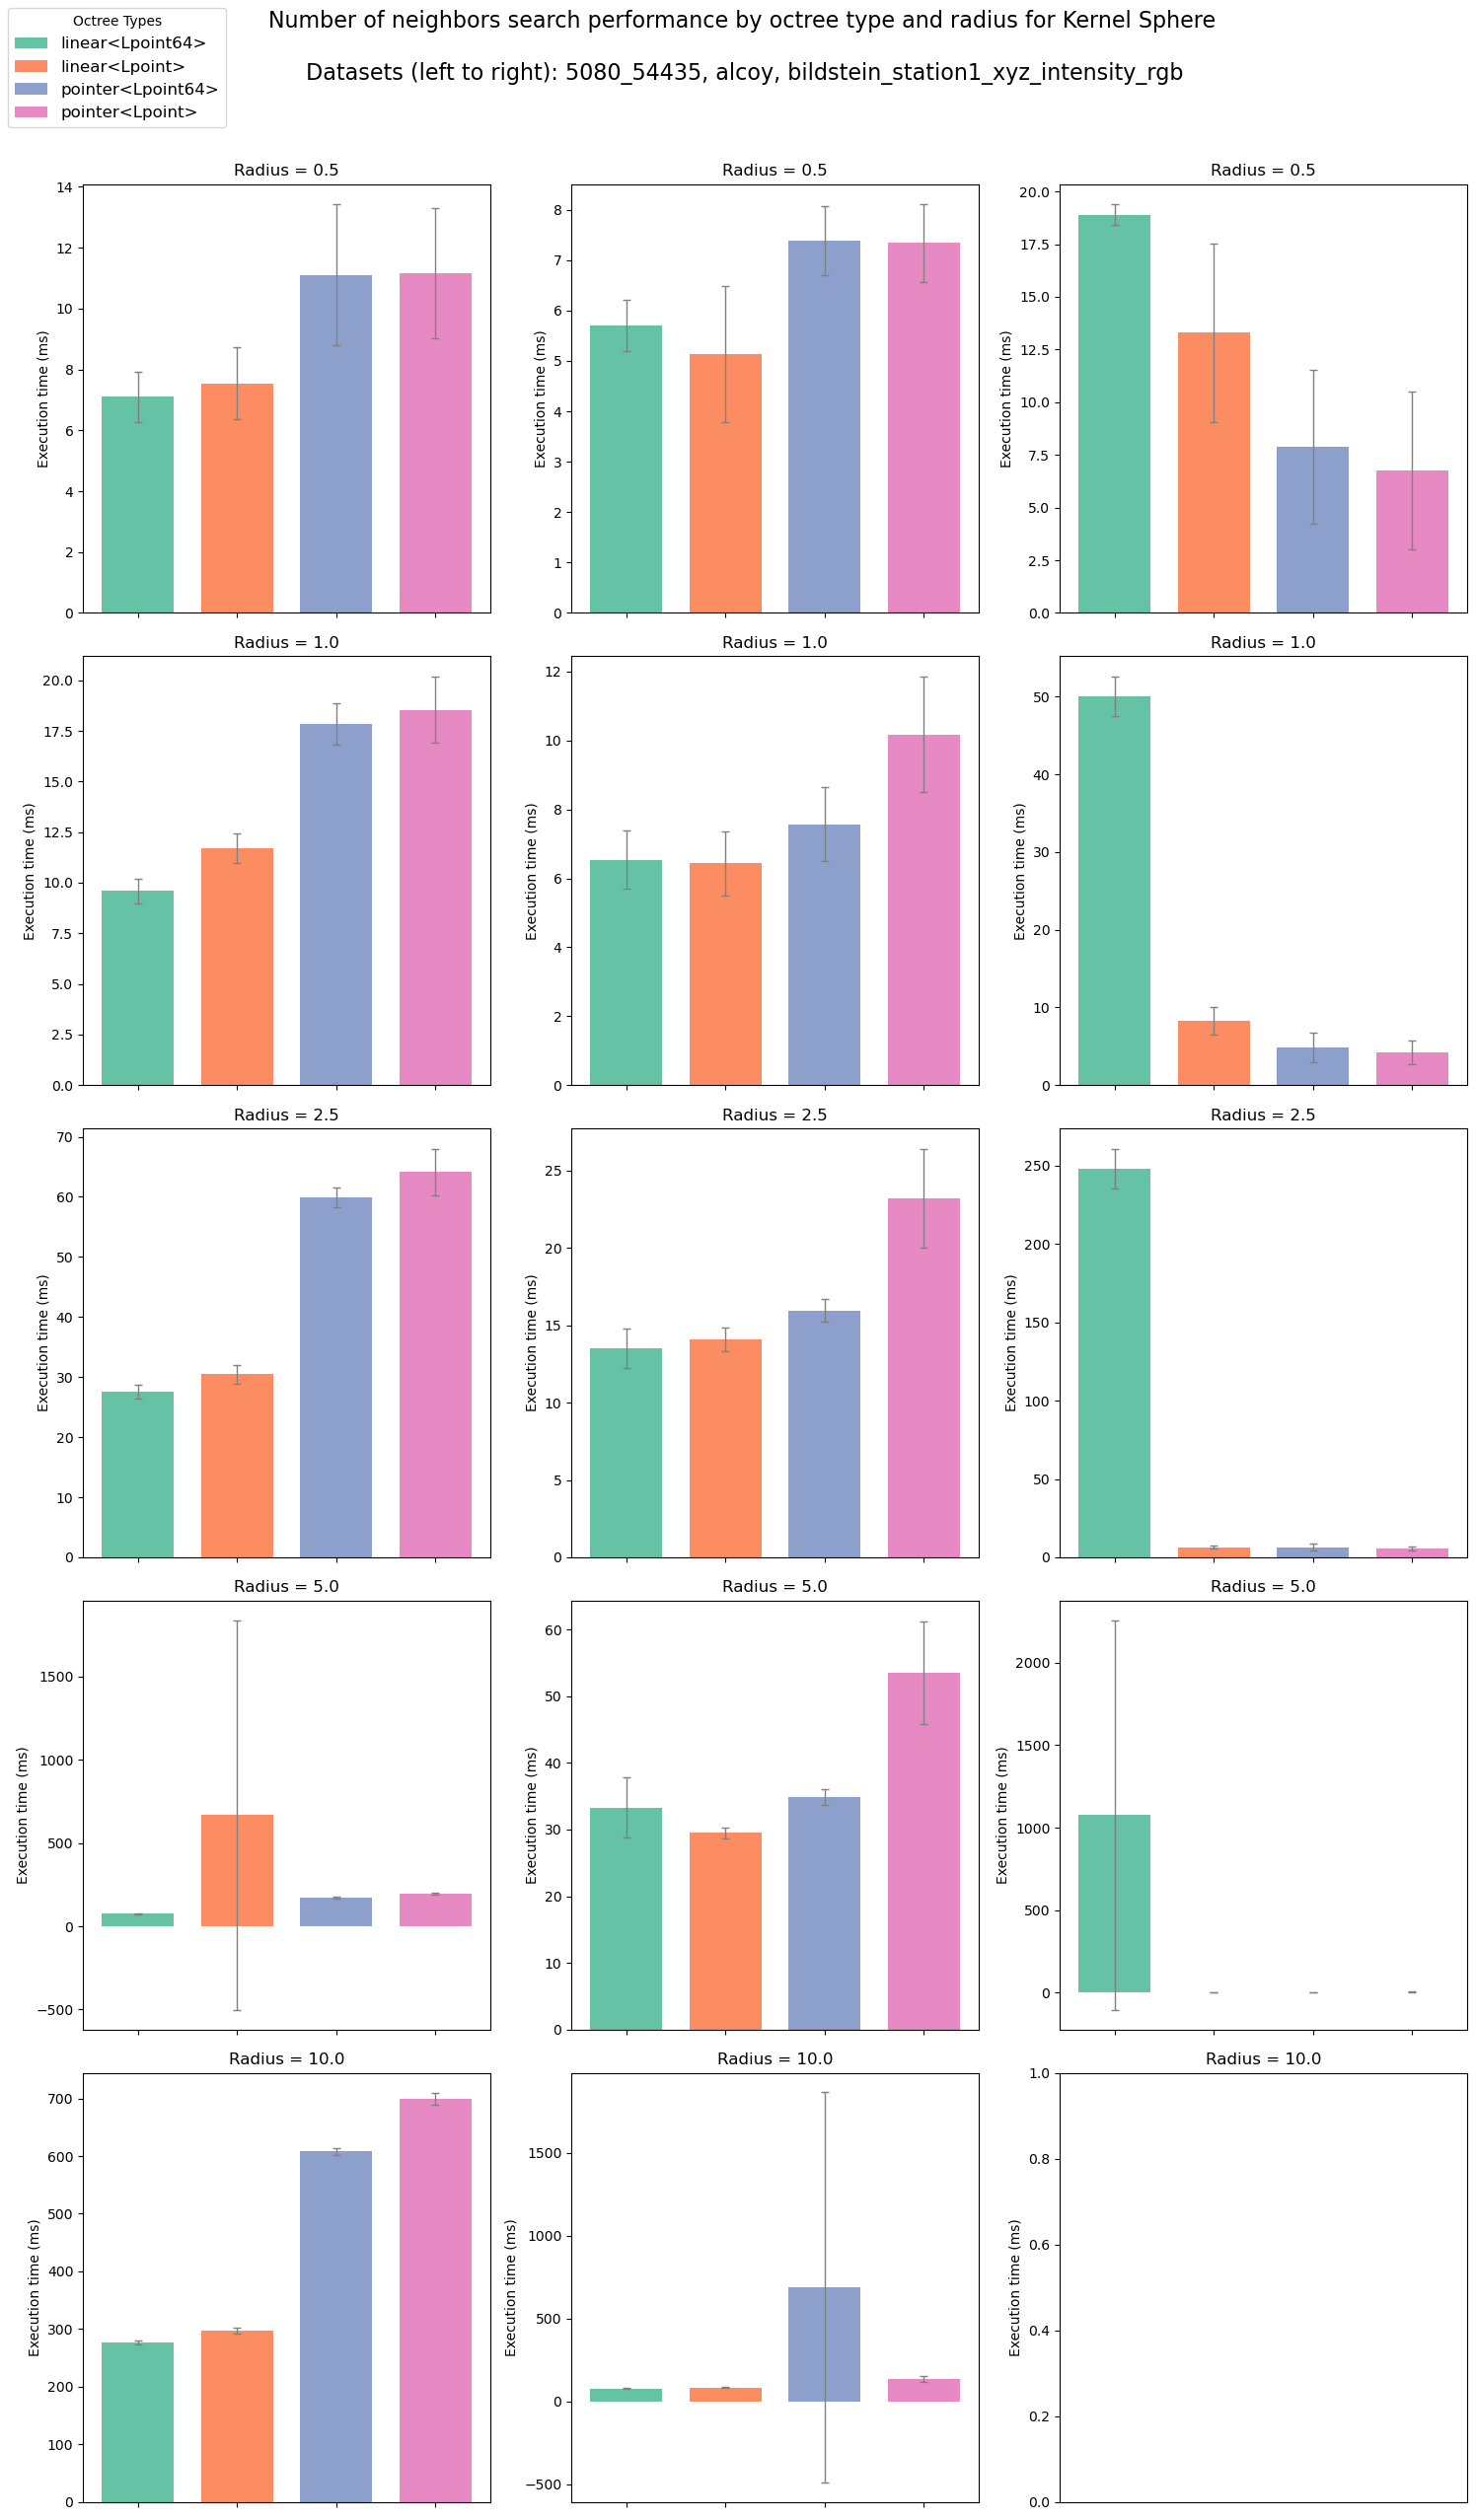

In [68]:
# Create the comparison plot for 'neighSearch'
fig = create_comparison_plot_matrix(dfs, "Sphere", 'numNeighSearch', 'Number of neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'num_neighbor_search_comparison.png'), dpi=300, bbox_inches='tight')